# CSE 152 Homework 3

# Problem 1: Perspective Projection [20 pts]
Consider a perspective projection where a point 
$$
P = \begin{bmatrix}x \\ y \\ z \end{bmatrix}
$$
is projected onto an image plane $\Pi'$ represented by $k = f'>0$ as shown in the following figure.

<img src="fig1.png">

The first, second, and third coordinate axes are denoted by $i$, $j$, $k$ respectively. 

Consider the projection of two rays in the world coordinate system
$$
Q_1 = [\text{7 -3 1}] + t[\text{8 2 4}]
$$
$$
Q_2 = [\text{3 -5 9}] + t[\text{8 2 4}]
$$
where $-\infty \leq t \leq -1$. 

Calculate the coordinates of the endpoints of the projection of the rays onto the image plane. Identify the vanishing point based on the coordinates.

Your calculation here
<br></br>
<br></br>
<br></br>
<br></br>

# Problem 2: Epipolar Geometry 
- (a) Suppose two cameras fixate on a point $P$ (see the figure below) in space such that their principal axes (the line passing the optical center and along the viewing direction) intersect at that point. Show that if the image coordinates are normalized so that the coordinate origin $(0,0)$ concides with the principal point (the intersection between the principal axes and the image plane), then the $\mathbf{F}_{33}$ element of the fundamental matrix is zero. [20 pts]

<img src="fig2.png" width="500px">

Your proof here
<br></br>
<br></br>
<br></br>
<br></br>

- Consider the case of two cameras viewing an object such that the second camera differs from the first one by a pure translation parallel to the image plane. Show that the epipolar lines in the two cameras are parallel. (hint: show by solid geometry) [10 extra credits]

Your proof here
<br></br>
<br></br>
<br></br>
<br></br>

# Problem 3: Fundamental Matrix [60 pts]
In this problem we will play around with sparse stereo matching methods. You will work a warrior figure. The problem contains two images ('warrior0.png', 'warrior1.png'), and two sets of matched points which is manually selected (wcor1.npy and wcor2.npy).

## 3.1 Set up 
Let's first plot the images and points.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter, convolve
import scipy
import warnings
from skimage.io import *
warnings.filterwarnings('ignore')

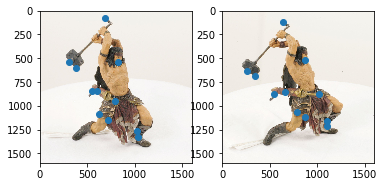

In [2]:
warriors = [imread('warrior0.png')/ 255., imread('warrior1.png') / 255.]
cor1 = np.load("wcor1.npy")
cor2 = np.load("wcor2.npy")

# plot the warriors and selected matching points
plt.subplot(121)
plt.imshow(warriors[0])
plt.scatter(cor1[0], cor1[1])
plt.subplot(122)
plt.imshow(warriors[1])
plt.scatter(cor2[0], cor2[1])

## 3.2 Compute fundamental matrix using 8-point algorithm [60 pts]

In this question, you need to implement 3 methods: ``eight_point``, ``fundamental_matrix``, ``compute_epipole``. 
1. In ``eight_point``, you should use 8-point algorithm to estimate the fundamental matrix. However, the provided points are larger than 8, so it becomes an over-determinated linear system. So you should get a least square solution for the fundamental matrix $F$, and ensure $rank(F) = 2$ by set the last singular value to be zero.
2. In ``fundamental_matrix``, you should perform normalization on image coordinates, and compute fundamental matrix using ``eight_point``, and then perform reverse normalization.
3. In ``compute_epipole``, you need to compute the epipole of two images based on the fundamental matrix
4. In ``plot_epipolar_lines``, you need to plot the epipolar lines based on the above methods. You can find the reference images ``epi_1.png, epi_2.png`` to compare with your results.

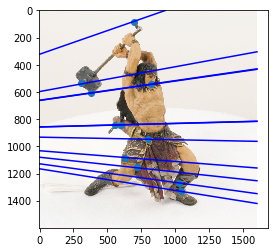

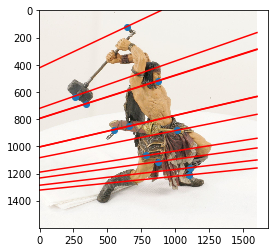

In [56]:
import numpy as np
import numpy
import matplotlib.pyplot as plt

def eight_point(x1,x2):
    """ Computes the fundamental matrix from corresponding points 
        (x1,x2 3*n arrays) using the 8 point algorithm.
        Each row in the A matrix below is constructed as
        [x'*x, x'*y, x', y'*x, y'*y, y', x, y, 1] 
    """
    
    n = x1.shape[1]
    if x2.shape[1] != n:
        raise ValueError("Number of points don't match.")
    
    # build matrix for equations
    A = np.stack((
          x1[0] * x2[0],  
          x1[0] * x2[1],  
          x1[0] * x2[2],
          x1[1] * x2[0],  
          x1[1] * x2[1],  
          x1[1] * x2[2],
          x1[2] * x2[0],  
          x1[2] * x2[1],  
          x1[2] * x2[2]
    )).T

    U, D, V = np.linalg.svd(A)
    F = V[-1].reshape(3, 3)
    
    # Enforcing rank 2 constraint by making the smallest singular value 0
    U, D, V = np.linalg.svd(F)
    D[-1] = 0
    D = np.diag(D)

    F = np.matmul(U, np.matmul(D, V))
    F = F / F[2, 2]
    return F

def fundamental_matrix(x1,x2):
    
    n = x1.shape[1]
    if x2.shape[1] != n:
        raise ValueError("Number of points don't match.")

    # normalize image coordinates
    x1, x2 = x1.copy(), x2.copy()
    
    x1_mean = x1[:2].mean(axis=1)
    x2_mean = x2[:2].mean(axis=1)
    
    std_1 = np.sqrt(np.mean((x1[:2] - x1[:2].mean()) ** 2))
    std_2 = np.sqrt(np.mean((x2[:2] - x2[:2].mean()) ** 2))
    
    sf1 = np.sqrt(2) / std_1 # scale factor for x1
    sf2 = np.sqrt(2) / std_2 # scale factor for x2
    
    sf1 = np.sqrt(1) / std_1 # scale factor for x1
    sf2 = np.sqrt(1) / std_2 # scale factor for x2
    
    N1 = np.array([[sf1, 0, -sf1 * x1_mean[0]],
                   [0, sf1, -sf1 * x1_mean[1]],
                   [0, 0, 1]])
    
    N2 = np.array([[sf2, 0, -sf2 * x2_mean[0]],
                   [0, sf2, -sf2 * x2_mean[1]],
                   [0, 0, 1]])
    
    x1 = np.dot(N1, x1)
    x2 = np.dot(N2, x2)
    
    # compute F with the normalized coordinates
    F = eight_point(x1,x2)

    # reverse normalization
    F = np.dot(N1.T, np.dot(F, N2))
    F = F / F[2, 2]

    return F

def compute_epipole(F, cor1, cor2):
    '''
    This function computes the epipoles for a given fundamental matrix 
    and corner point correspondences
    input:
    F: Fundamental matrix
    output:
    e1: corresponding epipole in image 1
    e2: epipole in image2
    '''
    ### YOUR CODE HERE
    e1 = np.dot(F, cor2)
    e2 = np.dot(F.T, cor1)
    ### YOUR CODE ENDS
    
    return e1, e2

def plot_epipolar_lines(img1,img2, cor1, cor2):
    """Plot epipolar lines on image given image, corners

    Args:
        img1: Image 1.
        img2: Image 2.
        cor1: Corners in homogeneous image coordinate in image 1 (3xn)
        cor2: Corners in homogeneous image coordinate in image 2 (3xn)

    """
    F = fundamental_matrix(cor1, cor2)
#     F = compute_fundamental_normalized(cor1, cor2)
    e1, e2 = compute_epipole(F, cor1, cor2)
    ### YOUR CODE HERE
    e1, e2 = e1.T, e2.T
    plt.scatter(cor1[0], cor1[1])
    
    plt.imshow(img1)
    for line_1 in e1:
        drawLine(line_1, img1, 'blue')
    plt.show()
    
    plt.scatter(cor2[0], cor2[1])
    plt.imshow(img2)
    for line_2 in e2:
        drawLine(line_2, img2, 'red')
    plt.show()
    ### YOUR CODE ENDS
    return

def drawLine(inputline, image, color):
    a, b, c = inputline[0], inputline[1], inputline[2]
    
    points = list()
    w, h = image.shape[:2]

    if b != 0:
        if 0 <= -c / b <= n:
            points.append([0, -c / b])
        if 0 <= (-c - a * m) / b <= n:
            points.append([m, (-c - a * m) / b])

    if a != 0:
        if 0 <= -c / a <= m:
            points.append([-c / a, 0])
        if 0 <= (-c - b * n) / a <= m:
            points.append([(-c - b * n) / a, n])

    points = np.array(points)
    plt.plot(points[:, 0], points[:, 1], color)

plot_epipolar_lines(warriors[0], warriors[1], cor1, cor2)